# <font color='blue'>Data Science Challenge @ ITA 2022</font>
# <font color='blue'>Equipe DIOMGIS</font>

## <font color='blue'>Fase 1</font>

### <font color='blue'>TEMA DO DESAFIO</font>

![title](..\data\image\logo.jpeg)

In [1]:
# Versão da Linguagem Python
from platform import python_version
print('Versão da Linguagem Python Usada Neste Jupyter Notebook:', python_version())

Versão da Linguagem Python Usada Neste Jupyter Notebook: 3.9.12


In [2]:
# Para atualizar um pacote, execute o comando abaixo no terminal ou prompt de comando:
# pip install -U nome_pacote

# Para instalar a versão exata de um pacote, execute o comando abaixo no terminal ou prompt de comando:
#!pip install nome_pacote==versão_desejada

# Depois de instalar ou atualizar o pacote, reinicie o jupyter notebook.

# Instala o pacote watermark. 
# Esse pacote é usado para gravar as versões de outros pacotes usados neste jupyter notebook.
#!pip install -q -U watermark

# Instala o pacote tensorboard-plugin-profile. 
# Esse pacote é usado para incrementar funcioalidades no Tensorboard.
#!pip install -U tensorboard-plugin-profile

# Instala pacote threadpoolctl
# Este pacote é uma dependência do pacote SMOTE
# !pip install threadpoolctl==3.1.0

In [3]:
# Bibliotecas e Frameworks

import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from keras.layers import Dense, Dropout
from keras.models import Sequential
from keras.optimizers import *
from keras.callbacks import ModelCheckpoint, TensorBoard, EarlyStopping, ReduceLROnPlateau, LambdaCallback, TerminateOnNaN
from keras.wrappers.scikit_learn import KerasClassifier
from keras.initializers import GlorotUniform
from keras.regularizers import L1L2
from tensorboard import notebook
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.metrics import roc_auc_score, make_scorer
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from time import time
from datetime import datetime
import os

In [4]:
# Versões dos pacotes usados neste jupyter notebook

%reload_ext watermark
%watermark -a "Equipe DIOMGIS" --iversions

Author: Equipe DIOMGIS

tensorboard: 2.10.0
seaborn    : 0.11.2
pandas     : 1.4.2
matplotlib : 3.5.1
numpy      : 1.22.3
keras      : 2.10.0
tensorflow : 2.10.0



In [5]:
sns.set_style('whitegrid')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
%load_ext tensorboard
%matplotlib inline
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [6]:
verbose = 2
seed = 25

np.random.seed(seed)

In [7]:
#Confirma se o TensorFlow pode acessar a GPU

device_name = tf.test.gpu_device_name()
if not device_name:
    raise SystemError('GPU device not found')
    
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [8]:
# Estado da GPU

!nvidia-smi

Thu Oct 13 00:27:39 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 516.94       Driver Version: 516.94       CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:65:00.0  On |                  N/A |
| 40%   29C    P2    27W / 220W |   1104MiB /  8192MiB |      5%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

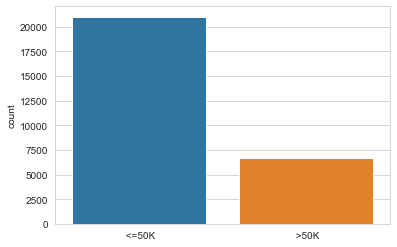

In [9]:
# Dados
import pickle

with open('data/census.pkl', 'rb') as f:
    [x_treino, y_treino, x_teste, y_teste] = pickle.load(f)
    
sns.countplot(y_treino);

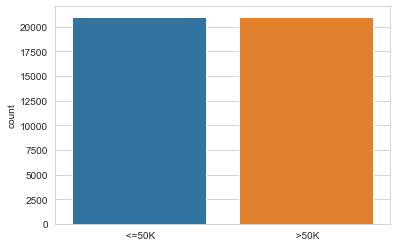

In [10]:
# Balanceamento de classes

sm = SMOTE(sampling_strategy = 'auto',
           random_state = None,
           k_neighbors = 5,
           n_jobs = None)

x_treino, y_treino = sm.fit_resample(x_treino, y_treino)

sns.countplot(y_treino);

In [11]:
# Parametros fixos de treinamento

epochs = 200
batch_size = 128
nKFold = 5
nPCA = 96

In [12]:
# Principal Component Analysis

reduceDim = PCA(n_components = nPCA,
                # copy = True,
                # whiten = False,
                # svd_solver = 'auto',
                # tol = 0.0,
                # iterated_power = 'auto',
                # n_oversamples = 10,
                # power_iteration_normalizer = 'auto',
                # random_state = None
               )

reduceDim.fit(x_treino)

x_treino = reduceDim.transform(x_treino)
x_teste = reduceDim.transform(x_teste)

In [13]:
from keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y_treino = le.fit_transform(y_treino)
y_teste = le.transform(y_teste)

y_treino = to_categorical(y_treino, num_classes = 2, dtype='float32')
y_teste = to_categorical(y_teste, num_classes = 2, dtype='float32')

In [14]:
'''
logdir = "logs/scalars/" + datetime.now().strftime("%Y%m%d-%H%M%S")
file_writer = tf.summary.create_file_writer(logdir + "/metrics")
file_writer.set_as_default()

def TBloss(epoch):
    tf.summary.scalar('logs', data = 8, step=epoch)
'''

'\nlogdir = "logs/scalars/" + datetime.now().strftime("%Y%m%d-%H%M%S")\nfile_writer = tf.summary.create_file_writer(logdir + "/metrics")\nfile_writer.set_as_default()\n\ndef TBloss(epoch):\n    tf.summary.scalar(\'logs\', data = 8, step=epoch)\n'

In [15]:
# Callbacks

tensorboard = TensorBoard(log_dir="logs_class/{}".format(time()))

earlystop = EarlyStopping(monitor='val_loss',
                              min_delta=0,
                              patience=20,
                              verbose = verbose,
                              restore_best_weights=True)

reduce_lr = ReduceLROnPlateau(monitor='loss',
                              factor=0.2,
                              patience=3,
                              mode="min",
                              verbose = verbose,
                              min_delta=0.00001,
                              min_lr=0)

lambdaCB = LambdaCallback(on_epoch_begin=None,
                          on_epoch_end=None,
                          on_batch_begin=None,
                          on_batch_end=None,
                          on_train_begin=None,
                          on_train_end=None)

callbacks = [tensorboard, earlystop, reduce_lr, lambdaCB, TerminateOnNaN()] # checkpoint,

In [16]:
def create_model(optimizer,
                 layers,
                 n_dense,
                 activationA,
                 activationB,
                 regL1,
                 regL2,
                 dropout):
    
    stdInitializer = GlorotUniform(seed)
    regularizer = L1L2(l1 = regL1, l2 = regL2)
    
    activations = [activationA, activationB]
    currentActivation = 1
    
    #----Alternar entre as funções de ativação-----
    func = activations[currentActivation]
    currentActivation = 1 - currentActivation
    #----------------------------------------------
    
    model = Sequential()
    
    model.add(Dense(n_dense,
                    kernel_initializer = stdInitializer,
                    kernel_regularizer = regularizer,
                    bias_regularizer = regularizer,
                    activation = func,
                    input_shape = (nPCA,)))
    
    
    
    #################################################################
    
    for layer in range(layers):
        
        #----Alternar entre as funções de ativação-----
        func = activations[currentActivation]
        currentActivation = 1 - currentActivation
        #----------------------------------------------
        
        model.add(Dropout(dropout))
        
        model.add(Dense(n_dense,
                        kernel_initializer = stdInitializer,
                        kernel_regularizer = regularizer,
                        bias_regularizer = regularizer,
                        activation = func))
    
    
    ##################################################################
    
    model.add(Dense(2,
                    kernel_initializer = stdInitializer,
                    kernel_regularizer = regularizer,
                    bias_regularizer = regularizer,
                    activation = 'softmax'))

    
    #--------------Loss Function--------------------------
    # Lbc = keras.losses.BinaryCrossentropy()
    Lcc = keras.losses.CategoricalCrossentropy()
    # Lscc = keras.losses.SparseCategoricalCrossentropy()
    #-----------------------------------------------------
    
    #--------------Metric Function------------------------
    Mauc = keras.metrics.AUC()
    #-----------------------------------------------------
    
    model.compile(loss = Lcc,
                  optimizer=optimizer,
                  metrics = [Mauc, "accuracy"])

    return model

In [17]:
# Modelo

model = KerasClassifier(build_fn = create_model,
                        verbose = verbose,
                        callbacks = callbacks)

In [18]:
#Pipeline

steps = [("model", model)]

estimator = Pipeline(steps, verbose = verbose)

In [19]:
# Definição dos parametros (GridSearch)

# Optimizer
learning_rate = 0.001

opt_SGD = SGD(
    learning_rate = learning_rate,
    momentum = 0.0,
    nesterov = False)

opt_RMSprop = RMSprop(
    learning_rate = learning_rate,
    rho = 0.9,
    momentum = 0.0,
    epsilon = 1e-07,
    centered = False)

opt_Adam = Adam(
    learning_rate = learning_rate,
    beta_1 = 0.9,
    beta_2 = 0.999,
    epsilon = 1e-07,
    amsgrad = False)

opt_Adadelta = Adadelta(
    learning_rate = learning_rate,
    rho = 0.95,
    epsilon = 1e-07)

opt_Adagrad = Adagrad(
    learning_rate = learning_rate,
    initial_accumulator_value = 0.1,
    epsilon = 1e-07)

opt_Adamax = Adamax(
    learning_rate = learning_rate,
    beta_1 = 0.9,
    beta_2 = 0.999,
    epsilon = 1e-07)

opt_Nadam = Nadam(
    learning_rate = learning_rate,
    beta_1 = 0.9,
    beta_2 = 0.999,
    epsilon = 1e-07)

opt_Ftrl = Ftrl(
    learning_rate = learning_rate,
    learning_rate_power = -0.5,
    initial_accumulator_value = 0.1,
    l1_regularization_strength = 0.0,
    l2_regularization_strength = 0.0,
    l2_shrinkage_regularization_strength = 0.0,
    beta = 0.0)

params_grid = {
    
    # optimizer [opt_SGD, opt_RMSprop, opt_Adam, opt_Adadelta, opt_Adagrad, opt_Adamax, opt_Nadam, opt_Ftrl]
    'model__optimizer': [opt_Adam],
    
    # Número de camadas
    'model__layers': [4, 5],
    
    # Neuronios por camada
    'model__n_dense': [32],
    
    # activation ['relu', 'sigmoid', 'tanh', 'selu', 'elu']
    'model__activationA': ['sigmoid'],
    'model__activationB': ['elu'],
    
    # Ridge regularizer
    'model__regL1': [0],
    
    # Lasso regularizer
    'model__regL2': [0],
    
    # Dropout regularizer
    'model__dropout': [0]
}

In [20]:
# Grid Search e Cross Validation
'''
my_roc_oac_score = make_scorer(score_func = roc_auc_score,
                             greater_is_better = True,
                             needs_proba = True,
                             needs_threshold = False,
                             average = 'macro',
                             sample_weight = None,
                             max_fpr = None,
                             multi_class = 'raise',
                             labels = None)
'''

grid = GridSearchCV(estimator = estimator,
                    # scoring = 'accuracy',
                    verbose = verbose,
                    return_train_score = False,
                    cv = nKFold,
                    # n_jobs = -2 # "-2": mantem 1 processador livre
                    # pre_dispatch = '2*n_jobs',
                    refit = True,
                    param_grid = params_grid)

# Apesar de y ser multilabel, deve ser passada sem OneRotEncoder
# https://github.com/keras-team/keras/issues/9331


In [21]:
# View grid

grid

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('model',
                                        <keras.wrappers.scikit_learn.KerasClassifier object at 0x000001E38002D190>)],
                                verbose=2),
             param_grid={'model__activationA': ['sigmoid'],
                         'model__activationB': ['elu'], 'model__dropout': [0],
                         'model__layers': [4, 5], 'model__n_dense': [32],
                         'model__optimizer': [<keras.optimizers.optimizer_v2.adam.Adam object at 0x000001E380045760>],
                         'model__regL1': [0], 'model__regL2': [0]},
             verbose=2)

In [22]:
# Monitoramento de Otimização

# %tensorboard --logdir=logs/
notebook.display(port=6006, height=1000)

Selecting TensorBoard with logdir logs_class (started 3:50:25 ago; port 6006, pid 4708).


In [23]:
# Treinamento

fit_params = {
    'model__batch_size': batch_size,
    'model__epochs': epochs,
    'model__verbose': verbose,
    'model__validation_data': (x_teste, y_teste),
    'model__shuffle': True,
    'model__validation_steps': None,
    'model__validation_freq': 1,
}

grid_result = grid.fit(x_treino, y_treino, **fit_params)

Fitting 5 folds for each of 2 candidates, totalling 10 fits
Epoch 1/200
263/263 - 4s - loss: 0.4792 - auc: 0.8494 - accuracy: 0.7645 - val_loss: 0.4488 - val_auc: 0.8806 - val_accuracy: 0.7783 - lr: 0.0010 - 4s/epoch - 16ms/step
Epoch 2/200
263/263 - 1s - loss: 0.3706 - auc: 0.9151 - accuracy: 0.8359 - val_loss: 0.4277 - val_auc: 0.8898 - val_accuracy: 0.7910 - lr: 0.0010 - 1s/epoch - 6ms/step
Epoch 3/200
263/263 - 1s - loss: 0.3608 - auc: 0.9193 - accuracy: 0.8398 - val_loss: 0.4538 - val_auc: 0.8766 - val_accuracy: 0.7662 - lr: 0.0010 - 1s/epoch - 5ms/step
Epoch 4/200
263/263 - 1s - loss: 0.3517 - auc: 0.9233 - accuracy: 0.8448 - val_loss: 0.4580 - val_auc: 0.8753 - val_accuracy: 0.7699 - lr: 0.0010 - 1s/epoch - 5ms/step
Epoch 5/200
263/263 - 2s - loss: 0.3448 - auc: 0.9263 - accuracy: 0.8465 - val_loss: 0.4059 - val_auc: 0.8999 - val_accuracy: 0.8010 - lr: 0.0010 - 2s/epoch - 6ms/step
Epoch 6/200
263/263 - 2s - loss: 0.3376 - auc: 0.9293 - accuracy: 0.8517 - val_loss: 0.4158 - val_a

Epoch 15/200
263/263 - 2s - loss: 0.3076 - auc_1: 0.9416 - accuracy: 0.8670 - val_loss: 0.4557 - val_auc_1: 0.8847 - val_accuracy: 0.7840 - lr: 0.0010 - 2s/epoch - 6ms/step
Epoch 16/200
263/263 - 1s - loss: 0.3053 - auc_1: 0.9425 - accuracy: 0.8683 - val_loss: 0.3809 - val_auc_1: 0.9142 - val_accuracy: 0.8158 - lr: 0.0010 - 1s/epoch - 6ms/step
Epoch 17/200
263/263 - 1s - loss: 0.3032 - auc_1: 0.9433 - accuracy: 0.8688 - val_loss: 0.4795 - val_auc_1: 0.8832 - val_accuracy: 0.7789 - lr: 0.0010 - 1s/epoch - 5ms/step
Epoch 18/200
263/263 - 1s - loss: 0.3024 - auc_1: 0.9436 - accuracy: 0.8677 - val_loss: 0.4248 - val_auc_1: 0.8985 - val_accuracy: 0.7977 - lr: 0.0010 - 1s/epoch - 5ms/step
Epoch 19/200
263/263 - 1s - loss: 0.2994 - auc_1: 0.9447 - accuracy: 0.8696 - val_loss: 0.4402 - val_auc_1: 0.8948 - val_accuracy: 0.7939 - lr: 0.0010 - 1s/epoch - 5ms/step
Epoch 20/200
263/263 - 1s - loss: 0.2969 - auc_1: 0.9456 - accuracy: 0.8713 - val_loss: 0.4008 - val_auc_1: 0.9066 - val_accuracy: 0.80

Epoch 29/200
263/263 - 1s - loss: 0.2769 - auc_2: 0.9528 - accuracy: 0.8820 - val_loss: 0.4779 - val_auc_2: 0.8931 - val_accuracy: 0.7834 - lr: 0.0010 - 1s/epoch - 6ms/step
Epoch 30/200
263/263 - 2s - loss: 0.2759 - auc_2: 0.9532 - accuracy: 0.8838 - val_loss: 0.4387 - val_auc_2: 0.9022 - val_accuracy: 0.7973 - lr: 0.0010 - 2s/epoch - 6ms/step
Epoch 31/200
Restoring model weights from the end of the best epoch: 11.
263/263 - 2s - loss: 0.2738 - auc_2: 0.9539 - accuracy: 0.8843 - val_loss: 0.4556 - val_auc_2: 0.8956 - val_accuracy: 0.7887 - lr: 0.0010 - 2s/epoch - 6ms/step
Epoch 31: early stopping
[Pipeline] ............. (step 1 of 1) Processing model, total=  48.3s
263/263 - 1s - loss: 0.3705 - auc_2: 0.9171 - accuracy: 0.8193 - 1s/epoch - 5ms/step
[CV] END model__activationA=sigmoid, model__activationB=elu, model__dropout=0, model__layers=4, model__n_dense=32, model__optimizer=<keras.optimizers.optimizer_v2.adam.Adam object at 0x000001E380045760>, model__regL1=0, model__regL2=0; tota

Epoch 13/200
263/263 - 2s - loss: 0.3267 - auc_4: 0.9327 - accuracy: 0.8457 - val_loss: 0.3387 - val_auc_4: 0.9273 - val_accuracy: 0.8346 - lr: 0.0010 - 2s/epoch - 7ms/step
Epoch 14/200
263/263 - 2s - loss: 0.3255 - auc_4: 0.9332 - accuracy: 0.8461 - val_loss: 0.3402 - val_auc_4: 0.9292 - val_accuracy: 0.8366 - lr: 0.0010 - 2s/epoch - 6ms/step
Epoch 15/200
263/263 - 2s - loss: 0.3239 - auc_4: 0.9338 - accuracy: 0.8459 - val_loss: 0.3546 - val_auc_4: 0.9200 - val_accuracy: 0.8248 - lr: 0.0010 - 2s/epoch - 6ms/step
Epoch 16/200
263/263 - 1s - loss: 0.3216 - auc_4: 0.9349 - accuracy: 0.8513 - val_loss: 0.3335 - val_auc_4: 0.9309 - val_accuracy: 0.8422 - lr: 0.0010 - 1s/epoch - 5ms/step
Epoch 17/200
263/263 - 1s - loss: 0.3212 - auc_4: 0.9350 - accuracy: 0.8489 - val_loss: 0.3438 - val_auc_4: 0.9252 - val_accuracy: 0.8309 - lr: 0.0010 - 1s/epoch - 5ms/step
Epoch 18/200
263/263 - 1s - loss: 0.3192 - auc_4: 0.9358 - accuracy: 0.8509 - val_loss: 0.3589 - val_auc_4: 0.9191 - val_accuracy: 0.82

Epoch 31/200
Restoring model weights from the end of the best epoch: 11.
263/263 - 2s - loss: 0.2786 - auc_5: 0.9523 - accuracy: 0.8813 - val_loss: 0.4462 - val_auc_5: 0.9022 - val_accuracy: 0.7953 - lr: 0.0010 - 2s/epoch - 6ms/step
Epoch 31: early stopping
[Pipeline] ............. (step 1 of 1) Processing model, total=  51.1s
263/263 - 1s - loss: 0.3658 - auc_5: 0.9161 - accuracy: 0.8152 - 1s/epoch - 5ms/step
[CV] END model__activationA=sigmoid, model__activationB=elu, model__dropout=0, model__layers=5, model__n_dense=32, model__optimizer=<keras.optimizers.optimizer_v2.adam.Adam object at 0x000001E380045760>, model__regL1=0, model__regL2=0; total time=  52.3s
Epoch 1/200
263/263 - 3s - loss: 0.4853 - auc_6: 0.8453 - accuracy: 0.7512 - val_loss: 0.4735 - val_auc_6: 0.8730 - val_accuracy: 0.7685 - lr: 0.0010 - 3s/epoch - 12ms/step
Epoch 2/200
263/263 - 2s - loss: 0.3727 - auc_6: 0.9151 - accuracy: 0.8382 - val_loss: 0.4698 - val_auc_6: 0.8755 - val_accuracy: 0.7697 - lr: 0.0010 - 2s/epo

Epoch 10/200
263/263 - 2s - loss: 0.3159 - auc_7: 0.9385 - accuracy: 0.8623 - val_loss: 0.3993 - val_auc_7: 0.9015 - val_accuracy: 0.7996 - lr: 0.0010 - 2s/epoch - 6ms/step
Epoch 11/200
263/263 - 2s - loss: 0.3109 - auc_7: 0.9405 - accuracy: 0.8654 - val_loss: 0.4110 - val_auc_7: 0.9009 - val_accuracy: 0.8010 - lr: 0.0010 - 2s/epoch - 7ms/step
Epoch 12/200
263/263 - 2s - loss: 0.3094 - auc_7: 0.9411 - accuracy: 0.8660 - val_loss: 0.4121 - val_auc_7: 0.8977 - val_accuracy: 0.7977 - lr: 0.0010 - 2s/epoch - 8ms/step
Epoch 13/200
263/263 - 2s - loss: 0.3060 - auc_7: 0.9424 - accuracy: 0.8681 - val_loss: 0.4310 - val_auc_7: 0.8978 - val_accuracy: 0.7916 - lr: 0.0010 - 2s/epoch - 6ms/step
Epoch 14/200
263/263 - 2s - loss: 0.3041 - auc_7: 0.9431 - accuracy: 0.8708 - val_loss: 0.4118 - val_auc_7: 0.9026 - val_accuracy: 0.7988 - lr: 0.0010 - 2s/epoch - 6ms/step
Epoch 15/200
263/263 - 2s - loss: 0.3028 - auc_7: 0.9436 - accuracy: 0.8704 - val_loss: 0.3863 - val_auc_7: 0.9128 - val_accuracy: 0.81

263/263 - 1s - loss: 0.4135 - auc_8: 0.8932 - accuracy: 0.8078 - 1s/epoch - 5ms/step
[CV] END model__activationA=sigmoid, model__activationB=elu, model__dropout=0, model__layers=5, model__n_dense=32, model__optimizer=<keras.optimizers.optimizer_v2.adam.Adam object at 0x000001E380045760>, model__regL1=0, model__regL2=0; total time=  47.9s
Epoch 1/200
263/263 - 3s - loss: 0.4595 - auc_9: 0.8610 - accuracy: 0.7682 - val_loss: 0.3539 - val_auc_9: 0.9225 - val_accuracy: 0.8307 - lr: 0.0010 - 3s/epoch - 12ms/step
Epoch 2/200
263/263 - 2s - loss: 0.3745 - auc_9: 0.9122 - accuracy: 0.8230 - val_loss: 0.3663 - val_auc_9: 0.9154 - val_accuracy: 0.8184 - lr: 0.0010 - 2s/epoch - 6ms/step
Epoch 3/200
263/263 - 2s - loss: 0.3639 - auc_9: 0.9166 - accuracy: 0.8278 - val_loss: 0.3452 - val_auc_9: 0.9247 - val_accuracy: 0.8328 - lr: 0.0010 - 2s/epoch - 7ms/step
Epoch 4/200
263/263 - 2s - loss: 0.3557 - auc_9: 0.9202 - accuracy: 0.8314 - val_loss: 0.3422 - val_auc_9: 0.9258 - val_accuracy: 0.8346 - lr: 

Epoch 18/200
329/329 - 2s - loss: 0.3087 - auc_10: 0.9409 - accuracy: 0.8627 - val_loss: 0.3806 - val_auc_10: 0.9127 - val_accuracy: 0.8115 - lr: 0.0010 - 2s/epoch - 6ms/step
Epoch 19/200
329/329 - 2s - loss: 0.3069 - auc_10: 0.9416 - accuracy: 0.8614 - val_loss: 0.3872 - val_auc_10: 0.9105 - val_accuracy: 0.8106 - lr: 0.0010 - 2s/epoch - 6ms/step
Epoch 20/200
329/329 - 2s - loss: 0.3050 - auc_10: 0.9423 - accuracy: 0.8629 - val_loss: 0.4139 - val_auc_10: 0.9051 - val_accuracy: 0.8004 - lr: 0.0010 - 2s/epoch - 6ms/step
Epoch 21/200
329/329 - 2s - loss: 0.3031 - auc_10: 0.9431 - accuracy: 0.8650 - val_loss: 0.4272 - val_auc_10: 0.8960 - val_accuracy: 0.7875 - lr: 0.0010 - 2s/epoch - 6ms/step
Epoch 22/200
329/329 - 2s - loss: 0.3018 - auc_10: 0.9436 - accuracy: 0.8650 - val_loss: 0.4155 - val_auc_10: 0.9041 - val_accuracy: 0.7965 - lr: 0.0010 - 2s/epoch - 6ms/step
Epoch 23/200
329/329 - 2s - loss: 0.2991 - auc_10: 0.9446 - accuracy: 0.8659 - val_loss: 0.3881 - val_auc_10: 0.9145 - val_ac

In [24]:
y_teste.shape

(4885, 2)

In [25]:
# Resultado do SearchGridCV

pd.concat([
           pd.DataFrame(grid.cv_results_)[['rank_test_score', 'mean_test_score', 'mean_fit_time']],
           pd.DataFrame(grid.cv_results_['params'])
          ],
           axis=1,
           join='inner').set_index('rank_test_score').sort_values('rank_test_score')

# Função score com base no SearchGridCV

,mean_test_score,mean_fit_time,model__activationA,model__activationB,model__dropout,model__layers,model__n_dense,model__optimizer,model__regL1,model__regL2
rank_test_score,,,,,,,,,,
1,0.803704,47.785747,sigmoid,elu,0,5,32,<keras.optimizers.optimizer_v2.adam.Adam objec...,0,0
2,0.802039,45.879516,sigmoid,elu,0,4,32,<keras.optimizers.optimizer_v2.adam.Adam objec...,0,0


In [26]:
best_params = grid.best_params_
best_model = grid.best_estimator_

In [27]:
# CategoricalCrossentropy, AUC e Accuracy - Função score do Modelo Keras encapsulado
best_model.score(x_treino, y_treino)

1315/1315 - 5s - loss: 0.3486 - auc_10: 0.9247 - accuracy: 0.8404 - 5s/epoch - 4ms/step


0.8403956890106201

In [28]:
# CategoricalCrossentropy, AUC e Accuracy - Função score do Modelo Keras encapsulado
best_model.score(x_teste, y_teste)

153/153 - 1s - loss: 0.3634 - auc_10: 0.9158 - accuracy: 0.8184 - 554ms/epoch - 4ms/step


0.8184237480163574

## Carregando o Conjunto de dados

## Análise Exploratória de Dados

### Análise n - XXX

## Pré-Processamento de Dados Para Construção de Modelos de Machine Learning

### Padronização

###  Construção, Treinamento e Avaliação do Modelo 1 com Regressão Linear (Benchmark)

### Avaliação do Modelo

### Métricas

### Resíduos

###  Construção, Treinamento e Avaliação do Modelo n com XXX

## Seleção do Modelo

## Conclusão

# Fim